# 9. Tackling the SketchRNN Dataset

_Exercise: Train a classification model for the SketchRNN dataset, available in TensorFlow Datasets._

In [22]:
import tensorflow as tf
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt

In [3]:
tf_download_root = "http://download.tensorflow.org/data/"
filename = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = tf.keras.utils.get_file(filename,
                                   tf_download_root + filename,
                                   cache_dir=".",
                                   extract=True)

1065301781/1065301781 ━━━━━━━━━━━━━━━━━━━━ 129s 0us/step


In [11]:
quickdraw_dir = Path(filepath)
train_files = sorted(
    [str(path) for path in quickdraw_dir.glob("training.tfrecord-*")]
)
eval_files = sorted(
    [str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")]
)

In [12]:
train_files

['datasets/quickdraw_tutorial_dataset_v1_extracted/training.tfrecord-00000-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/training.tfrecord-00001-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/training.tfrecord-00002-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/training.tfrecord-00003-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/training.tfrecord-00004-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/training.tfrecord-00005-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/training.tfrecord-00006-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/training.tfrecord-00007-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/training.tfrecord-00008-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/training.tfrecord-00009-of-00010']

In [13]:
eval_files

['datasets/quickdraw_tutorial_dataset_v1_extracted/eval.tfrecord-00000-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/eval.tfrecord-00001-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/eval.tfrecord-00002-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/eval.tfrecord-00003-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/eval.tfrecord-00004-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/eval.tfrecord-00005-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/eval.tfrecord-00006-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/eval.tfrecord-00007-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/eval.tfrecord-00008-of-00010',
 'datasets/quickdraw_tutorial_dataset_v1_extracted/eval.tfrecord-00009-of-00010']

In [14]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [15]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [16]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [17]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [18]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [19]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

I0000 00:00:1741611804.010035   63329 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2874 MB memory:  -> device: 0, name: Quadro P600, pci bus id: 0000:01:00.0, compute capability: 6.1


In [20]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

2025-03-10 14:03:27.296934: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144


sketches = tf.Tensor(
[[[-0.02755906 -0.0062893   0.        ]
  [-0.01181102 -0.03773582  0.        ]
  [-0.00393701 -0.27672958  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.11206897 -0.02745098  0.        ]
  [ 0.14655171 -0.0745098   0.        ]
  [ 0.13793105 -0.09019607  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.01960784  0.01581028  0.        ]
  [ 0.13333334  0.03162056  0.        ]
  [ 0.20392157  0.03162056  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[-0.2588235  -0.04487181  0.        ]
  [-0.21960783  0.01923078  0.        ]
  [-0.0784314   0.14102566  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

2025-03-10 14:03:27.576350: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


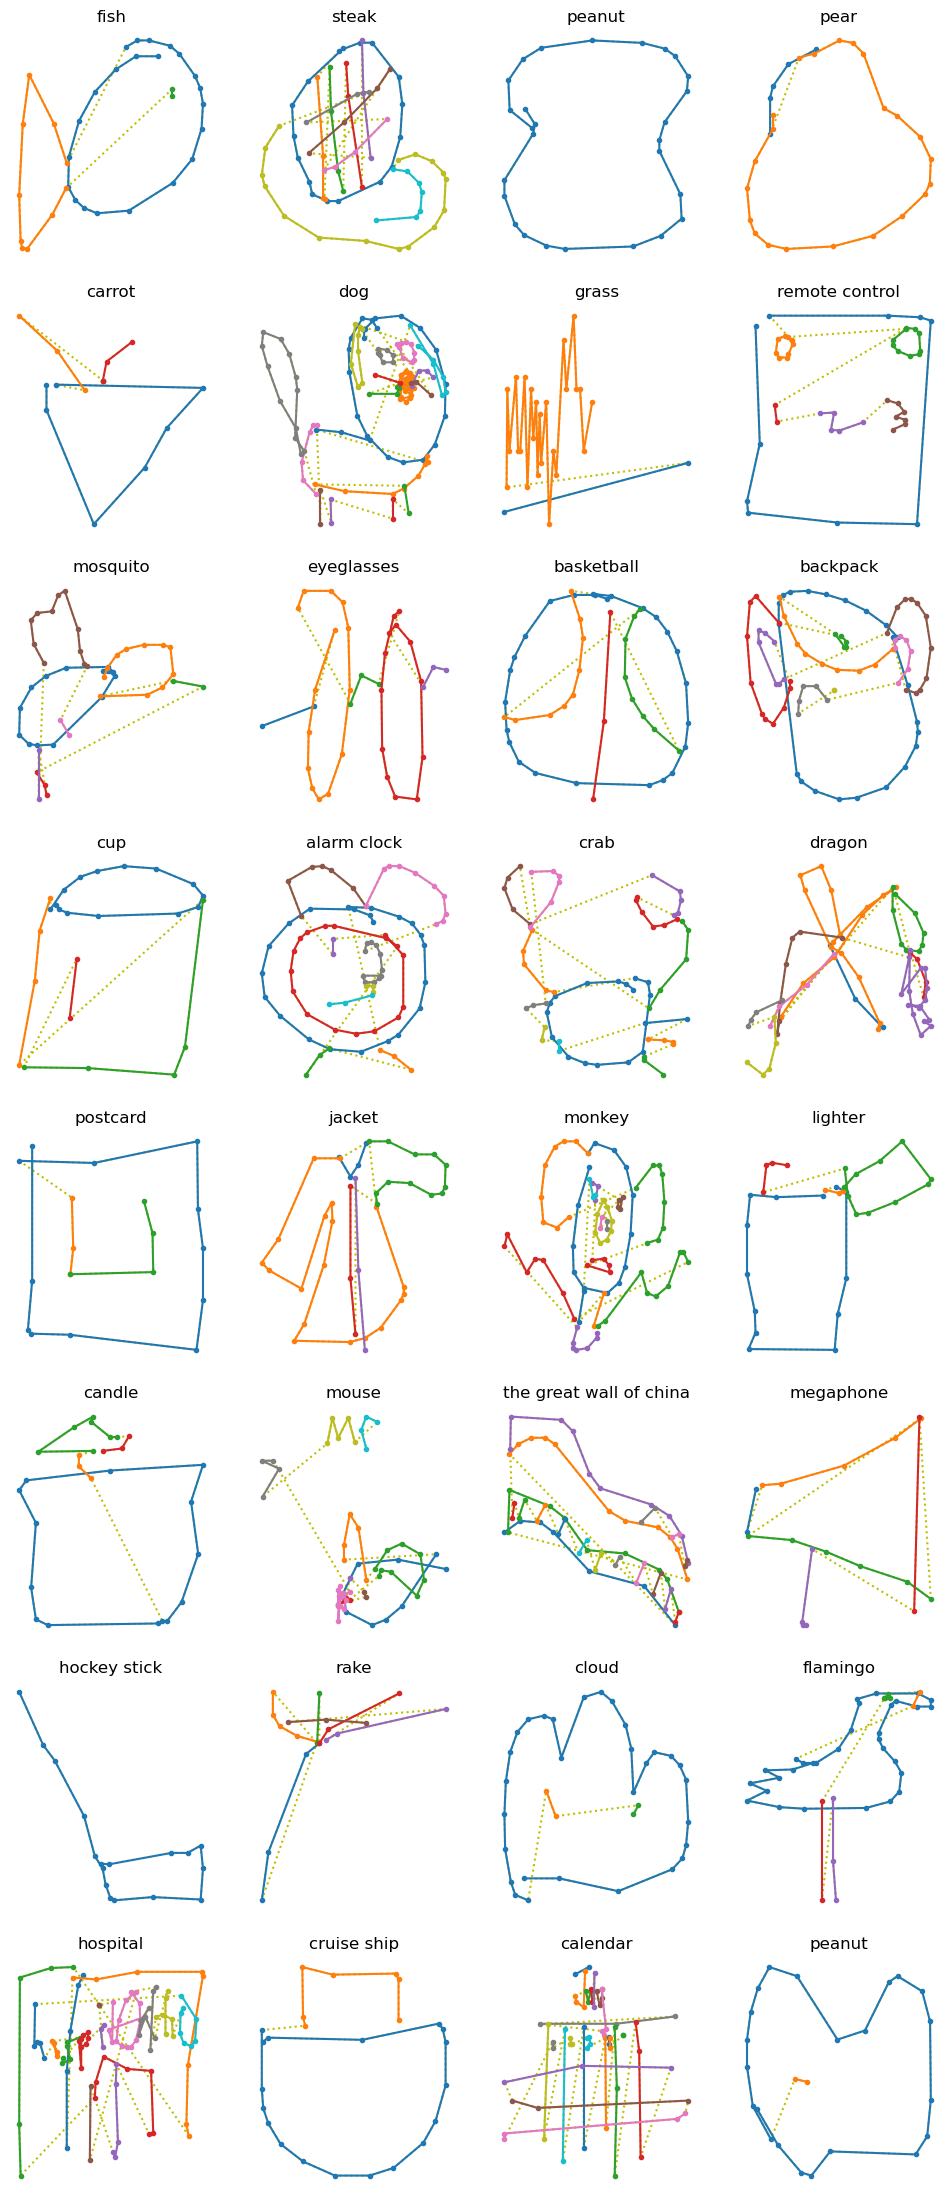

2025-03-10 14:04:32.250376: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [23]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = sketch[:, :2].cumsum(axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

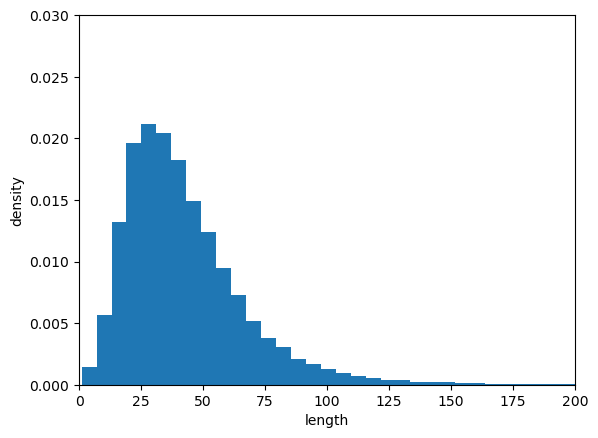

In [24]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [25]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set)

Epoch 1/2


I0000 00:00:1741612219.515683   74854 cuda_dnn.cc:529] Loaded cuDNN version 90700


 107813/Unknown 2592s 24ms/step - accuracy: 0.0735 - loss: 4.9036 - sparse_top_k_categorical_accuracy: 0.1923

2025-03-10 14:53:27.866375: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-10 14:53:27.866554: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 114960218635426175
2025-03-10 14:53:27.866576: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14624873296608777211
2025-03-10 14:53:27.866584: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17702990822383477903
/home/martin/miniconda/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


107813/107813 ━━━━━━━━━━━━━━━━━━━━ 2648s 25ms/step - accuracy: 0.0735 - loss: 4.9036 - sparse_top_k_categorical_accuracy: 0.1923 - val_accuracy: 0.3090 - val_loss: 3.0964 - val_sparse_top_k_categorical_accuracy: 0.5918
Epoch 2/2


2025-03-10 14:54:23.932911: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7765088359758770412
2025-03-10 14:54:23.932973: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11167471829061751226
2025-03-10 14:54:23.932983: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14875364893969599990


107813/107813 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3430 - loss: 2.9011 - sparse_top_k_categorical_accuracy: 0.6308

2025-03-10 15:34:38.496341: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-10 15:34:38.496497: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 114960218635426175
2025-03-10 15:34:38.496510: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14624873296608777211
2025-03-10 15:34:38.496517: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17702990822383477903
2025-03-10 15:34:38.496522: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 3723579787870715727
2025-03-10 15:34:38.496542: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 10882077461300553772


107813/107813 ━━━━━━━━━━━━━━━━━━━━ 2467s 23ms/step - accuracy: 0.3430 - loss: 2.9011 - sparse_top_k_categorical_accuracy: 0.6308 - val_accuracy: 0.4240 - val_loss: 2.4709 - val_sparse_top_k_categorical_accuracy: 0.7124


2025-03-10 15:35:31.401586: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7765088359758770412
2025-03-10 15:35:31.401652: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11167471829061751226
2025-03-10 15:35:31.401666: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14875364893969599990
2025-03-10 15:35:31.401671: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7815924684650743434


In [27]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

5392/5392 ━━━━━━━━━━━━━━━━━━━━ 74s 13ms/step


In [28]:
np.mean(tf.keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

0.5974451

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


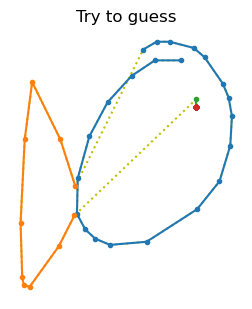

Top-5 predictions:
  1. mouse 20.729%
  2. pond 9.212%
  3. frying pan 7.143%
  4. cloud 5.684%
  5. sea turtle 5.296%
Answer: fish


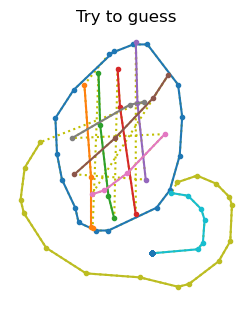

Top-5 predictions:
  1. bee 29.720%
  2. wheel 13.484%
  3. basketball 12.528%
  4. onion 6.778%
  5. soccer ball 5.447%
Answer: steak


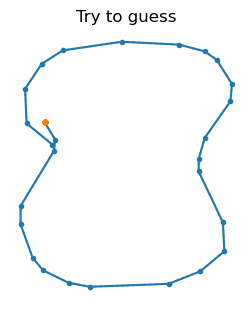

Top-5 predictions:
  1. bread 27.376%
  2. octagon 22.960%
  3. hexagon 20.317%
  4. peanut 2.945%
  5. wine bottle 2.502%
Answer: peanut


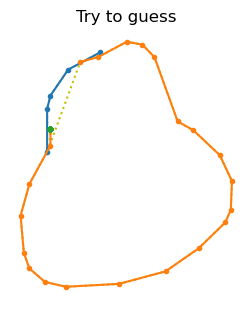

Top-5 predictions:
  1. pear 23.719%
  2. onion 18.787%
  3. octagon 13.304%
  4. hexagon 13.129%
  5. circle 4.243%
Answer: pear


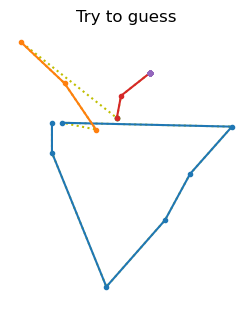

Top-5 predictions:
  1. fork 66.167%
  2. hexagon 3.399%
  3. octagon 2.804%
  4. carrot 2.359%
  5. screwdriver 1.756%
Answer: carrot


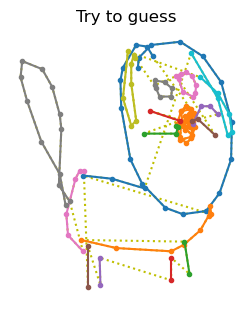

Top-5 predictions:
  1. crab 15.924%
  2. cow 15.779%
  3. raccoon 8.911%
  4. tiger 7.336%
  5. pig 6.628%
Answer: dog


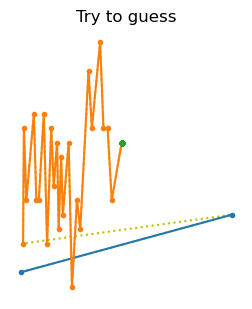

Top-5 predictions:
  1. grass 54.130%
  2. toothbrush 11.689%
  3. paintbrush 4.511%
  4. feather 4.022%
  5. see saw 3.504%
Answer: grass


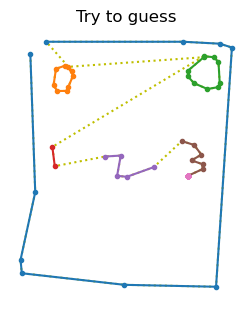

Top-5 predictions:
  1. remote control 28.600%
  2. stove 8.091%
  3. skyscraper 5.889%
  4. dishwasher 5.810%
  5. calendar 5.125%
Answer: remote control


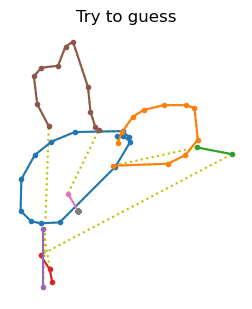

Top-5 predictions:
  1. mosquito 48.575%
  2. ant 11.568%
  3. scorpion 4.460%
  4. bee 3.539%
  5. yoga 3.344%
Answer: mosquito


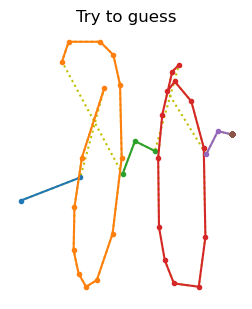

Top-5 predictions:
  1. eyeglasses 69.416%
  2. dumbbell 20.249%
  3. skateboard 1.688%
  4. ant 0.952%
  5. bowtie 0.605%
Answer: eyeglasses


In [29]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))